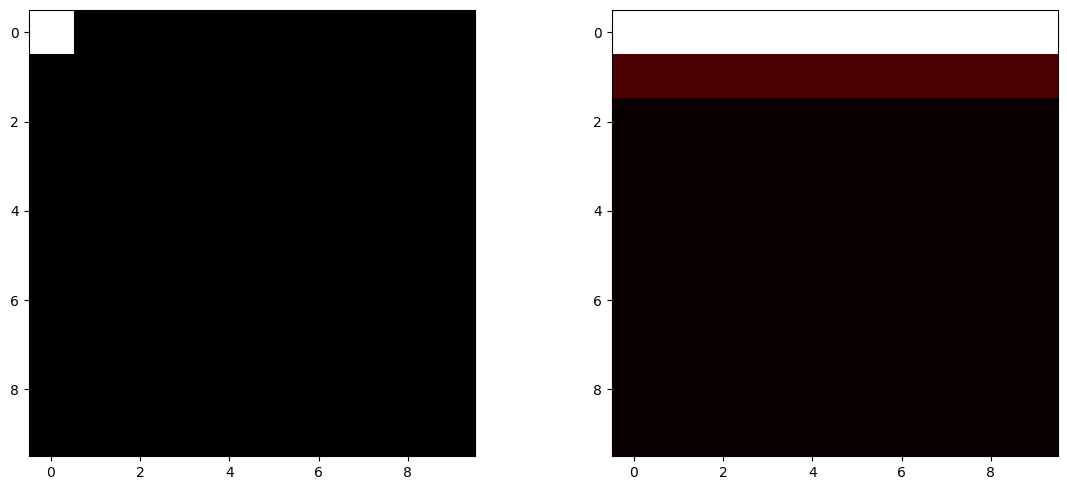

In [33]:
import numpy as np
import matplotlib.pyplot as plt

SIZE = 10
game_map = np.zeros((SIZE, SIZE))
game_map[0][0] = 0.1

sound_map = np.zeros((SIZE, SIZE))
sound_map[0] = 0.1
sound_map[1] = 0.01

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(game_map, cmap='gray')
im1 = ax[1].imshow(sound_map, cmap='hot') # , norm='log')
# fig.colorbar(im1, ax=ax[1], label='Value (log scale)')
plt.tight_layout()
plt.show()

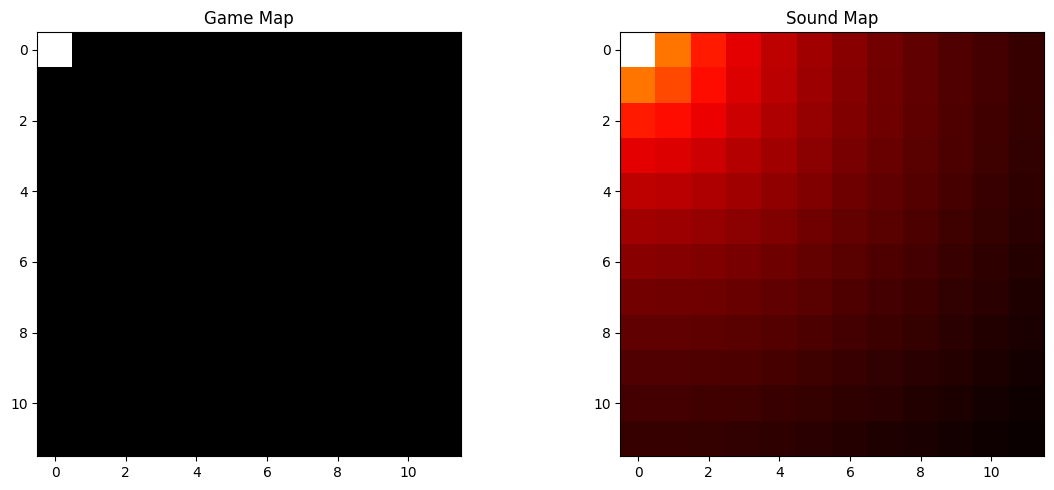

In [40]:
import numpy as np
import matplotlib.pyplot as plt

SIZE = 12
game_map = np.zeros((SIZE, SIZE))
game_map[0][0] = 0.1

sound_map = np.zeros((SIZE, SIZE))
x, y = np.meshgrid(np.arange(SIZE), np.arange(SIZE))

x0, y0 = 0, 0  # start pos
r = np.sqrt((x - x0)**2 + (y - y0)**2) 
sound_map = 0.0001 / (r**2 + 1e-2)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(game_map, cmap='gray')
ax[0].set_title('Game Map')

ax[1].imshow(sound_map, cmap='hot', norm='log')
ax[1].set_title('Sound Map')

plt.tight_layout()
plt.show()

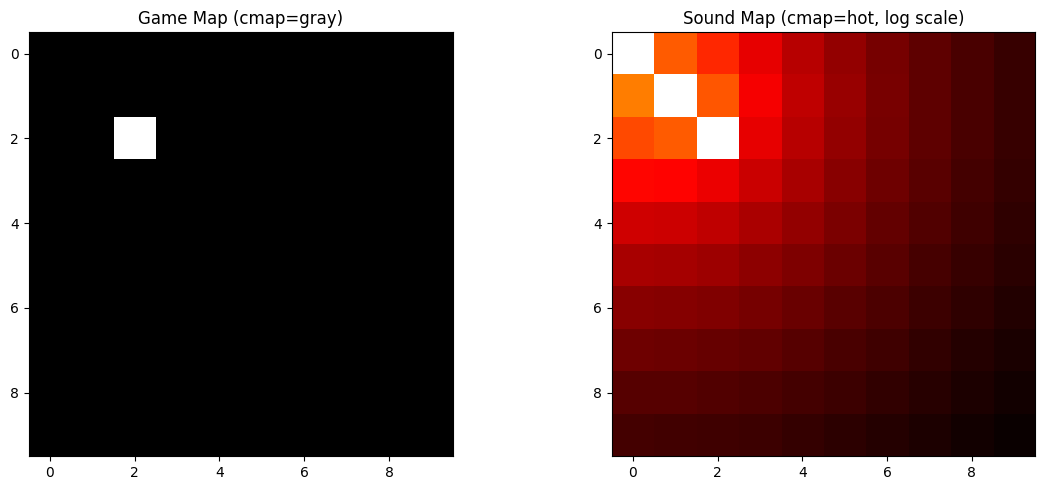

In [42]:
import numpy as np
import matplotlib.pyplot as plt

SIZE = 10
# game_map 설정: 벽 위치 (0.1은 벽)
game_map = np.zeros((SIZE, SIZE))
game_map[2,2] = 0.1  # (0,0)에 벽

# sound_map 설정: 직접 소리 + 반사 소리
sound_map = np.zeros((SIZE, SIZE))
x, y = np.meshgrid(np.arange(SIZE), np.arange(SIZE))
x0, y0 = 1, 1  # 소리원 위치 (벽과 겹치지 않게 (1,1)로 이동)
A = 0.0001  # 초기 소리 세기
epsilon = 1e-2  # 0으로 나누기 방지
R = 0.8  # 반사 계수

# 직접 소리: 1/r^2 감쇠
r_direct = np.sqrt((x - x0)**2 + (y - y0)**2)
I_direct = A / (r_direct**2 + epsilon)

# 벽에 의한 차단: (0,0)이 벽이므로, 경로 확인
# 간단히 (0,0)을 통과하는 경우만 체크 (직선 경로 근사)
mask = np.ones_like(sound_map)  # 차단 마스크
for i in range(SIZE):
    for j in range(SIZE):
        # (x0,y0)에서 (i,j)까지 경로에 (0,0) 벽이 있는지 확인
        # 직선 경로 근사: (0,0)이 경로에 포함되면 차단
        if (i == 0 and j == 0) or (game_map[i,j] == 0.1):
            mask[i,j] = 0  # 벽 위치는 소리 0

# 반사 소리: 벽이 y=0 평면이라 가정, 소리원 (x0,y0)의 가상 소리원 (-x0,y0)
# 반사 경로 거리
x_reflect, y_reflect = -x0, y0  # 가상 소리원 위치
r_reflect = np.sqrt((x - x_reflect)**2 + (y - y_reflect)**2)
I_reflect = (A * R) / (r_reflect**2 + epsilon)

# 최종 소리 세기: 직접 + 반사 (차단된 곳은 0)
sound_map = (I_direct + I_reflect) * mask

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# 첫 번째 subplot: game_map with cmap='gray'
ax[0].imshow(game_map, cmap='gray')
ax[0].set_title('Game Map (cmap=gray)')

# 두 번째 subplot: sound_map with cmap='hot'
ax[1].imshow(sound_map, cmap='hot', norm='log')  # 로그 스케일링
ax[1].set_title('Sound Map (cmap=hot, log scale)')

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 설정
SIZE = 50  # 그리드 크기
dx = 1.0   # 공간 스텝
dt = 0.1   # 시간 스텝 (CFL 조건 준수)
c = 1.0    # 기본 파동 속도
steps = 100  # 시뮬레이션 스텝 수

# 파동 필드 초기화
u = np.zeros((SIZE, SIZE))      # 현재
u_prev = np.zeros((SIZE, SIZE)) # 이전
u_next = np.zeros((SIZE, SIZE)) # 다음

# 초기 조건: 중심에 가우시안 펄스
x, y = np.meshgrid(np.linspace(-SIZE/2, SIZE/2, SIZE), np.linspace(-SIZE/2, SIZE/2, SIZE))
sigma = 3.0
u = np.exp(-(x**2 + y**2) / (2 * sigma**2))
u_prev = u.copy()

# 벽 설정 (game_map: 1=벽)
game_map = np.zeros((SIZE, SIZE))
game_map[SIZE//2 - 5:SIZE//2 + 5, SIZE//2] = 1  # 수직 벽

# 파동 속도 맵: 벽에서 c=0 (차단)
c_map = c * (1 - game_map)

# 시뮬레이션 루프
for t in range(steps):
    # Laplace 연산자 계산
    laplacian = (np.roll(u, 1, axis=0) + np.roll(u, -1, axis=0) +
                 np.roll(u, 1, axis=1) + np.roll(u, -1, axis=1) - 4 * u) / dx**2
    
    # 다음 스텝 업데이트
    u_next = 2 * u - u_prev + (c_map * dt)**2 * laplacian
    
    # 경계 조건: 반사 (Neumann)
    u_next[0, :] = u_next[1, :]
    u_next[-1, :] = u_next[-2, :]
    u_next[:, 0] = u_next[:, 1]
    u_next[:, -1] = u_next[:, -2]
    
    # 벽에서 차단 (Dirichlet: u=0)
    u_next[game_map == 1] = 0
    
    # 필드 업데이트
    u_prev = u.copy()
    u = u_next.copy()

# 시각화 (colorbar 없이)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(game_map, cmap='gray')
ax[0].set_title('Game Map (Walls)')
ax[1].imshow(u, cmap='hot', norm='symlog')  # symlog 스케일로 동적 범위 강조
ax[1].set_title('Wave Field (cmap=hot, symlog scale)')
plt.tight_layout()
plt.show()